# From Physics to Finance: an in-depth look into the Physical Phenomenon of Brownian motion and its Applications in Finance.

**Project Overview:**

1.  **The Physics:**
    *   Start with a simple **1D Symmetric Random Walk** i.e. a coin flip.
    *   Rescale it until it smoothes out into **Brownian Motion**.
    *   Verify it against the **Diffusion Equation** (Fick's Law).

2.  **The Finance:**
    *   Use Brownian motion to power the **Geometric Brownian Motion (GBM)** model.
    *   Simulate stock paths and price **European Call Options**.
    *   Check our math against the famous **Black–Scholes formula**.

3.  **The Reality Check:**
    *   Compare our idealized model against **real market data** (Apple, Bitcoin, Gold). Does the Black-Scholes model hold up in the real world?

  Required imports and random number generator initialization are shown below.

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import yfinance as yf
from scipy.stats import probplot

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.size"] = 12

rng = np.random.default_rng(seed=42)


## 1. The Discrete Random Walk

Imagine a walker on a line. At every time step $n$, they flip a coin:
*   **Heads:** Step right (+1)
*   **Tails:** Step left (-1)

Mathematically, the position $X_n$ is:
$$ X_n = X_{n-1} + Z_n, \quad X_0 = 0 $$
where $Z_n \in \{-1, +1\}$ represents the random coin flip (50/50 probability).

**Key Stats:**
*   **Mean ($\mathbb{E}[X_n] = 0$):** On average, the walker doesn't drift anywhere.
*   **Variance ($\text{Var}(X_n) = n$):** The uncertainty grows linearly with time.
*   **Spread ($|X_n| \sim \sqrt{n}$):** Most walkers stay within a distance of $\pm c\sqrt{n}$.

This $\sqrt{n}$ scaling is key here. It defines how diffusion works, whether it's salt in water or volatility in a market.

The function below, `random_walk_1d`, generates these trajectories for us.

In [94]:
def random_walk_1d(n_steps, n_walks = 1):
  steps = rng.choice([-1, 1], size=(n_walks, n_steps)) #coin flip

  x = np.zeros((n_walks, n_steps + 1))

  x[:, 1:] = np.cumsum(steps, axis=1)

  return x

### Interpreting the Randomness

Let's simulate 10 of these walkers taking 100 steps each.

**What to watch for in the plot:**
*   **Individuality:** Each path is jagged and unpredictable.
*   **Group Behavior:** The ensemble stays roughly centered at 0.
*   **The Envelope:** I've plotted dashed lines at $\pm \sqrt{n}$. Notice how the "cloud" of paths generally expands along these curves.


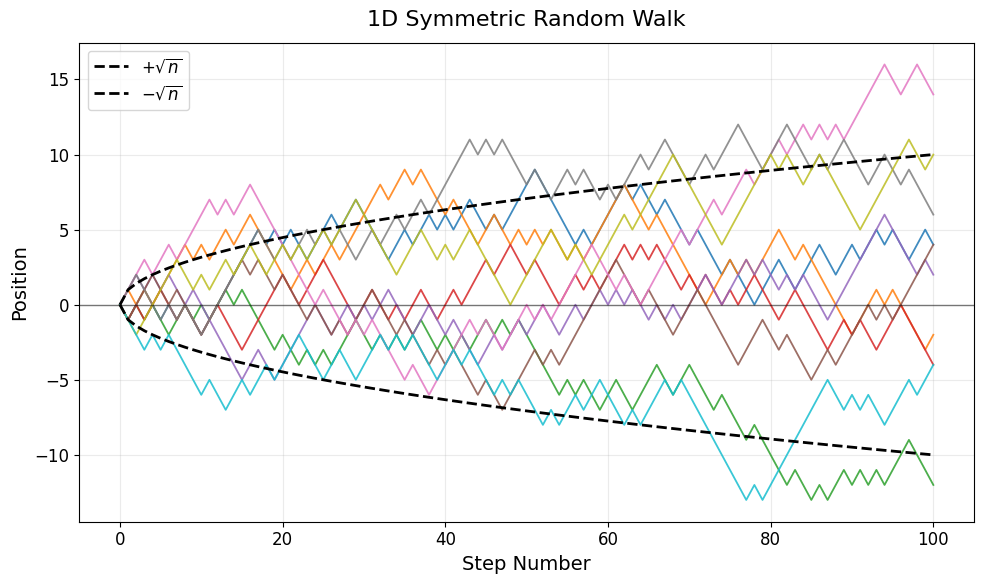

In [95]:
n_walks = 10
n_steps = 100

X = random_walk_1d(n_steps, n_walks) #generate our walks

colors = plt.cm.tab10(np.linspace(0, 1, n_walks))

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_walks):
    ax.plot(X[i], color=colors[i % 10], linewidth=1.3, alpha=0.85)

n = np.arange(n_steps + 1)
upper = np.sqrt(n) #show scaling
lower = -np.sqrt(n)

ax.plot(n, upper, 'k--', linewidth=2, label=r'$+\sqrt{n}$')
ax.plot(n, lower, 'k--', linewidth=2, label=r'$-\sqrt{n}$')

ax.set_xlabel("Step Number", fontsize=14)
ax.set_ylabel("Position", fontsize=14)
ax.set_title("1D Symmetric Random Walk", fontsize=16, pad=12)
ax.axhline(0, color="black", linewidth=1, alpha=0.5)
ax.grid(alpha=0.25)
ax.legend()

plt.tight_layout()
plt.show()

## 2. Scaling Up: From Steps to Smoothness ("Smootherness")

How do we turn a random walk into smooth **Brownian Motion**?

We shrink the step size, take a total time $T$ and chop it into $n$ tiny intervals $\Delta t = T/n$, and for each interval, we flip our coin $Z \in \{-1, +1\}$.

As time gets smaller, we must shrink the step size by the **square root** of time:

$$ \Delta x = \sqrt{\Delta t} $$

This specific scaling is crucial. If we scale linearly ($\,\Delta x \sim \Delta t\,$), the motion vanishes. If we don't scale enough, it explodes. The square root is the perfect zone where meaningful diffusion occurs.

The scaled process is:

$$
W^{(n)}_t = \sum \text{steps} = \sum_{i=1}^{k} Z_i \sqrt{\Delta t}
$$

As $n \to \infty$, this morphs into **Standard Brownian Motion ($W_t$)**.

This is known as **Donsker’s Invariance Principle**. It's the mathematical guarantee that if you zoom out far enough, all symmetric random walks look the same.

In [96]:
def scaled_random_walk_1d(T, n_steps, n_paths = 1):
  dt = T/n_steps #convert our arbitrary step n to a step in time
  step_size = np.sqrt(dt) #scale accordingly

  xi = rng.choice([-1, 1], size=(n_paths, n_steps)) #coin flip again

  dx = step_size * xi

  x = np.zeros((n_paths, n_steps + 1))
  x[:, 1:] = np.cumsum(dx, axis=1)

  t = np.linspace(0, T, n_steps + 1)

  return t, x


### Visualizing the Limit

Below, I simulate the scaled process.

**Qualitatively**, notice how:

1.  **No more blocks:** The paths look like rough, continuous curves rather than a jagged walk.
2.  **Self-similarity:** If you zoomed in, it would look just as jagged.
3.  **Variance matches time:** The spread of the paths at time $t$ is proportional to $\sqrt{t}$ (or variance $\propto t$).


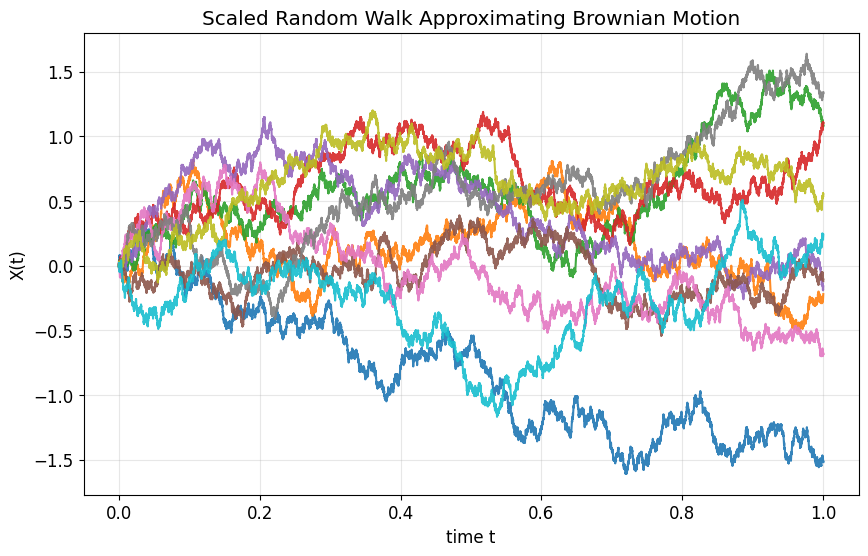

In [97]:
T = 1.0
n_walks = 10
n_steps = 10000
t, X = scaled_random_walk_1d(T, n_steps, n_walks)

fig, ax = plt.subplots(figsize=(10, 6))
for i in range(n_walks):
    ax.plot(t, X[i], alpha=0.9)

ax.set_xlabel("time t")
ax.set_ylabel("X(t)")
ax.set_title("Scaled Random Walk Approximating Brownian Motion")
ax.grid(alpha=0.3)
plt.show()

### The Connection to Fick's Law (Diffusion)

Consider many identical particles released at $x=0$. Their random motion produces a spreading probability density $p(x,t)$, which is governed by the **diffusion equation**:

$$ \frac{\partial p}{\partial t} = D \frac{\partial^2 p}{\partial x^2} $$

For our standard Brownian motion (where $D=1/2$), the solution is a Gaussian that flattens over time:

$$ p(x,t) = \frac{1}{\sqrt{2\pi t}} e^{-\frac{x^2}{2t}} $$

**To Test:**
We'll run 20,000 walks, and plot a histogram based off of where the particles end up. If the math holds, it should closely hug the red theoretical curve.

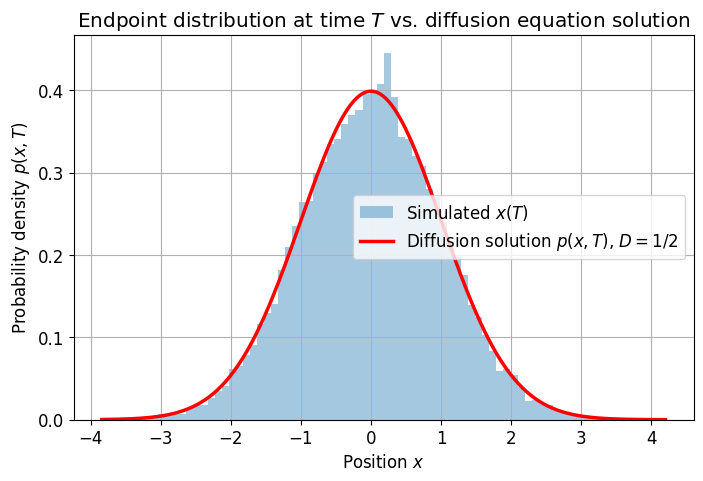

Empirical mean at time T: 0.0077 (theory: 0.0000)
Empirical variance at time T: 0.9871 (theory: 1.0000)


In [98]:
T = 1.0          # total time
n_steps = 10000   # lots of steps
n_paths = 20000  # high number of independent paths for good statistics

# Simulate many scaled random walk paths (approx BM)
t, X_paths = scaled_random_walk_1d(T, n_steps, n_paths)

# Take positions at final time T for all paths
x_T = X_paths[:, -1]

# diffusion constant
D = 0.5

def diffusion_pdf(x, t, D=0.5):
    return 1.0 / np.sqrt(4 * np.pi * D * t) * np.exp(-x**2 / (4 * D * t))

# Set up plot range
x_min, x_max = x_T.min(), x_T.max()
x_grid = np.linspace(x_min, x_max, 400)

pdf_T = diffusion_pdf(x_grid, T, D=D)

fig, ax = plt.subplots(figsize=(8, 5))

# plot histogram normalized to probability density
ax.hist(x_T, bins=80, density=True, alpha=0.4, color="C0", label="Simulated $x(T)$")

ax.plot(x_grid, pdf_T, "r-", lw=2.5, label=r"Diffusion solution $p(x,T)$, $D = 1/2$")

ax.set_xlabel(r"Position $x$")
ax.set_ylabel(r"Probability density $p(x,T)$")
ax.set_title(r"Endpoint distribution at time $T$ vs. diffusion equation solution")
ax.legend()
ax.grid(True)

plt.show()

print(f"Empirical mean at time T: {x_T.mean():.4f} (theory: 0.0000)")
print(f"Empirical variance at time T: {x_T.var():.4f} (theory: {T:.4f})")


### Mean Squared Displacement (MSD)

Another way to check our work is the **Mean Squared Displacement**:

$$ \text{MSD}(t) = \langle x(t)^2 \rangle $$

Put simply: On average, how far squared is the particle from home?

For standard diffusion, this should grow **linearly** with time:

$$ \langle x(t)^2 \rangle = t $$

If our plot is a straight line with slope 1, we've successfully simulated Brownian motion.

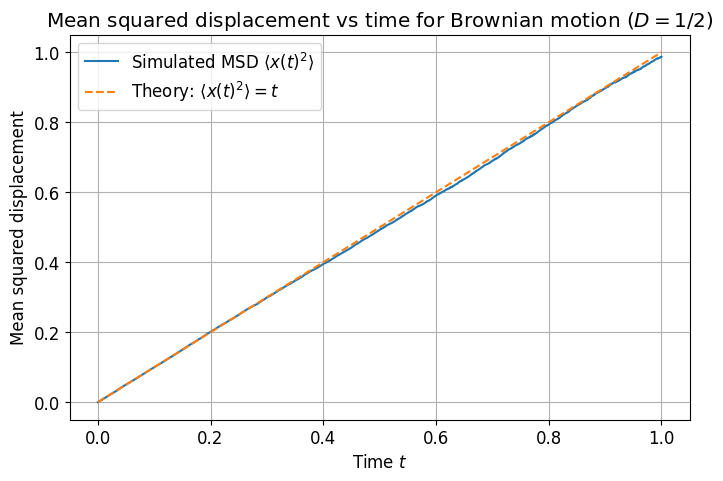

MSD at T (simulated): 0.9872
MSD at T (theory):     1.0000


In [99]:
MSD = np.mean(X_paths**2, axis=0) # average over all paths

MSD_theory = t  # since we chose D = 1/2 earlier

# Plot MSD vs time and compare to theory
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(t, MSD, label=r"Simulated MSD $\langle x(t)^2 \rangle$", color="C0")
ax.plot(t, MSD_theory, "--", label=r"Theory: $\langle x(t)^2 \rangle = t$", color="C1")

ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"Mean squared displacement")
ax.set_title(r"Mean squared displacement vs time for Brownian motion ($D = 1/2$)")
ax.legend()
ax.grid(True)

plt.show()

print(f"MSD at T (simulated): {MSD[-1]:.4f}")
print(f"MSD at T (theory):     {T:.4f}")


## 3.Geometric Brownian Motion (GBM) for Finance

We built **Brownian motion** ($W_t$) to model a random particle. Now, we use it to model a **stock price** ($S_t$).

**The Model:**
We assume the **instantaneous percentage return** ($dS/S$) follows Brownian motion with drift:

$$ \frac{dS_t}{S_t} = \mu dt + \sigma dW_t $$

**The Solution (Log Returns):**
Using Itô's Calculus, this implies that the **log-returns** are normally distributed:

$$ \ln\left(\frac{S_t}{S_0}\right) \sim N\left( (\mu - \frac{1}{2}\sigma^2)t, \, \sigma^2 t \right) $$

Which gives us the explicit price equation:
$$ S_t = S_0 e^{(\mu - \frac{1}{2}\sigma^2)t + \sigma W_t} $$

**Our Simulation Scenario:**
In the code below, we simulate a hypothetical stock with these characteristics:
*   **Start Price ($S_0$):** \$100
*   **Drift ($\mu$):** 10% per year (Optimistic!)
*   **Volatility ($\sigma$):** 20% per year (Standard for a blue-chip stock)
*   **Time ($T$):** 1 Year

Notice the $-\frac{1}{2}\sigma^2$ term in the exponent. This is the "volatility drag" i.e. a mathematical proof that volatility eats away at compound returns over time.

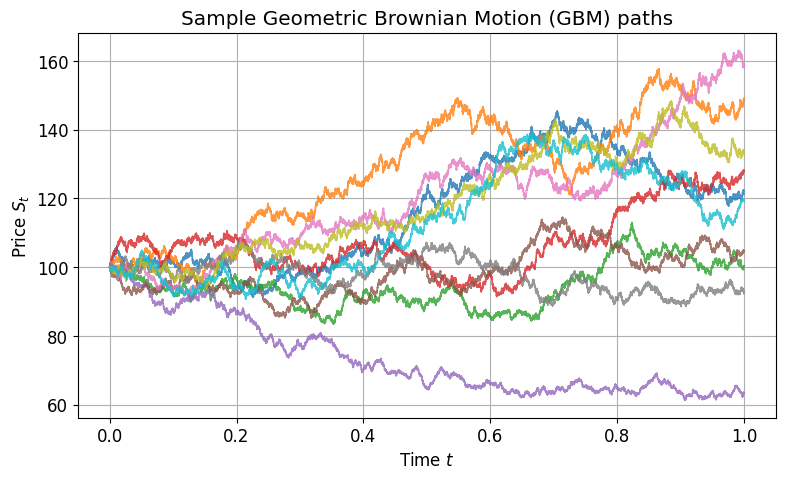

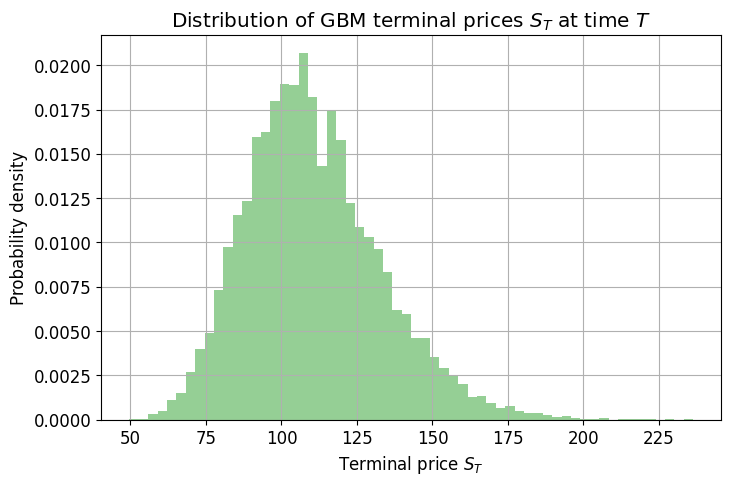

Empirical mean of log S_T: 4.6866
Theoretical mean of log S_T: 4.6852
Empirical var of log S_T:  0.0404
Theoretical var of log S_T: 0.0400


In [100]:
S0 = 100.0      # initial stock price
mu = 0.10       # projected annual return
sigma = 0.20    # volatility
T = 1.0         # time horizon (1 year)

t, W_paths = scaled_random_walk_1d(T, n_steps, n_paths)  #generate new paths just because

t_row = t[np.newaxis, :]

#exact GBM solution
drift_term = (mu - 0.5 * sigma**2) * t_row
S_paths = S0 * np.exp(drift_term + sigma * W_paths)

n_show = 10

fig, ax = plt.subplots(figsize=(9, 5))

for i in range(n_show):
    ax.plot(t, S_paths[i, :], lw=1.2, alpha=0.8)

ax.set_xlabel(r"Time $t$")
ax.set_ylabel(r"Price $S_t$")
ax.set_title(r"Sample Geometric Brownian Motion (GBM) paths")
ax.grid(True)

plt.show()

S_T = S_paths[:, -1]

fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(S_T, bins=60, density=True, alpha=0.5, color="C2")
ax.set_xlabel(r"Terminal price $S_T$")
ax.set_ylabel(r"Probability density")
ax.set_title(r"Distribution of GBM terminal prices $S_T$ at time $T$")
ax.grid(True)

plt.show()

log_S_T = np.log(S_T)
print(f"Empirical mean of log S_T: {log_S_T.mean():.4f}")
print(f"Theoretical mean of log S_T: {np.log(S0) + (mu - 0.5 * sigma**2) * T:.4f}")
print(f"Empirical var of log S_T:  {log_S_T.var():.4f}")
print(f"Theoretical var of log S_T: {sigma**2 * T:.4f}")


## 4. Pricing Options: Monte Carlo vs. Black-Scholes

Here we see if we can price a **European Call Option** using our **Geometric Brownian Motion.**

*   **The Contract:** The right to buy the stock at Strike Price $K$ at time $T$.
*   **The Payoff:** $\max(S_T - K, 0)$. If the stock goes high, you profit. If it drops, you lose nothing (but the initial price of the option).

### The Risk-Neutral Probability

To price an option fairly, we do not use the physical drift $ \mu $ (e.g., 10%). Instead, we replace it with the **risk-free interest rate** \( r \). This is known as *risk-neutral pricing* and relies on the assumption that arbitrage opportunities are quickly eliminated in an idealized, efficient market.

Under this measure, the stock price path is:

$$ S_T = S_0 e^{(r - \frac{1}{2}\sigma^2)T + \sigma \sqrt{T} Z} $$

Where $Z \sim N(0,1)$.

### Two Ways to Find the Price of the Option ($C_0$)

**1. The Simulation Approach (Monte Carlo)**  
We use Geometric Brownian Motion as the random engine to explore many possible future market scenarios.

Here, we:

• Generate 200,000 possible terminal prices $ S_T $ by sampling the GBM distribution.  
• Evaluate the option payoff for each simulated future.  
• Average these payoffs and discount them back to today using $ e^{-rT} $ to obtain the option price.

**2. The Formula Way (Black-Scholes)**
We check our answer against the closed-form solution:

$$ C_0 = S_0 \Phi(d_1) - K e^{-rT} \Phi(d_2) $$

Where:

$ \Phi(x) $ is the cumulative distribution function of a standard normal random variable:

$$\Phi(x) = \mathbb{P}(Z \le x)$$

and $$d_1 = \frac{\ln\!\left(\frac{S_t}{K}\right) + \left(r  + \tfrac{1}{2}\sigma^2\right)(T - t)}{\sigma\sqrt{T - t}}$$

and
$$d_2 = d_1 - \sigma\sqrt{T - t}$$

Note: Generally, a dividend yield term $ -q $ appears in $ d_1 $. For the sake of this project, we assume our stock pays no dividends (i.e. $ q = 0 $).

If our simulation is good, these two numbers should match almost perfectly.


In [101]:
S0 = 100.0      # initial stock price
K = 100.0       # strike price
r = 0.05        # risk-free interest rate (5% per year)
sigma = 0.20    # volatility (20% per year)
T = 1.0

N = 200_000     # number of MC samples

Z = rng.normal(loc=0.0, scale=1.0, size=N)

# risk neutral prices
S_T = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * math.sqrt(T) * Z)

#European call payoff
payoffs = np.maximum(S_T - K, 0.0)

print(payoffs)
print(Z)

# MC estimate
discount_factor = math.exp(-r * T)
C0_MC = discount_factor * payoffs.mean()

# error calc
payoff_std = payoffs.std(ddof=1)
std_error = discount_factor * payoff_std / math.sqrt(N)

# B-S solution
def norm_cdf(x: float) -> float:
    return 0.5 * (1.0 + math.erf(x / math.sqrt(2.0)))

d1 = (math.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
d2 = d1 - sigma * math.sqrt(T)

C0_BS = S0 * norm_cdf(d1) - K * discount_factor * norm_cdf(d2)

print(f"Monte Carlo price:      {C0_MC:.4f}")
print(f"Monte Carlo std. error: {std_error:.4f}")
print(f"Black–Scholes price:    {C0_BS:.4f}")
print(f"Absolute error:         {abs(C0_MC - C0_BS):.4f}")


[11.90457032  7.09744725  0.         ...  0.         27.26040667
 50.22404243]
[ 0.41238136  0.19284478 -1.24439189 ... -0.63852917  1.05532624
  1.88478805]
Monte Carlo price:      10.4674
Monte Carlo std. error: 0.0329
Black–Scholes price:    10.4506
Absolute error:         0.0168


## 5. The Reality Check: Models vs. Markets

Up to this point, we've been living in a mathematical utopia:
*   Prices move smoothly.
*   Risk is constant ($\sigma$ is fixed).
*   Returns follow a perfect normal distribution.

Now, we test this model against real data in 3 very different assets:
1.  **AAPL (Apple):** A mature, blue-chip stock.
2.  **BTC-USD (Bitcoin):** A volatile cryptocurrency.
3.  **GLD (Gold):** A safe-haven commodity.

For each asset, we calculate daily log-returns $r_t = \ln(S_t/S_{t-1})$ and look for three things:

*   **Histogram:** Shows a normal distribution with the real distribution.
*   **The Q-Q Plot:** Displays how much "extreme" events occur
*   **Volatility Clustering:** In real markets, volatility is constantly changing.
*   **Price Comparison** We average the returns predicted by 10 simulations with our model.

In [102]:
def get_asset_data(ticker, start="2015-01-01", end="2025-01-01"):
    data = yf.download(ticker, start=start, end=end,
                       auto_adjust=True, progress=False)
    # load data on daily close prices
    close_data = data["Close"]
    prices = close_data.iloc[:, 0].astype(float).dropna()

    log_returns = np.log(prices / prices.shift(1)).dropna().astype(float)



    mu_daily    = float(log_returns.mean())
    sigma_daily = float(log_returns.std(ddof=1))

    mu_annual    = mu_daily * 252
    sigma_annual = sigma_daily * np.sqrt(252)

    return prices, log_returns, mu_annual, sigma_annual

def plot_asset_row(ticker, prices, log_returns, mu_annual, sigma_annual, axes_row):
    # Unpack the 4 axes for this row
    ax_hist, ax_qq, ax_vol, ax_price = axes_row

    # real histogram + normal distribution
    x = np.linspace(log_returns.min(), log_returns.max(), 400)
    ax_hist.hist(log_returns, bins=60, density=True, alpha=0.5)
    ax_hist.plot(x, norm.pdf(x, log_returns.mean(), log_returns.std()), "r-")
    ax_hist.set_title(f"{ticker}: Histogram")

    # QQ plot
    probplot(log_returns, dist="norm", plot=ax_qq)
    ax_qq.set_title(f"{ticker}: Q–Q Plot")

    # volatility
    ax_vol.plot(np.abs(log_returns), lw=0.7)
    ax_vol.set_title(f"{ticker}: |r_t| clustering")

    # GBM simulation
    n = len(prices)
    dt = 1/252
    t = np.arange(n) * dt
    S0 = float(prices.iloc[0])

    n_sims = 10 # generate 10 simulations for each stock predicition
    Z = rng.normal(0, 1, size=(n_sims, n-1))  #montecarlo random engine
    W = np.concatenate([np.zeros((n_sims, 1)), np.cumsum(np.sqrt(dt) * Z, axis=1)], axis=1) #random normal to GBM

    S0 = float(prices.iloc[0])
    t = np.arange(n) * dt

    S_paths = S0 * np.exp((mu_annual - 0.5 * sigma_annual**2) * t + sigma_annual * W)

    S_mean = S_paths.mean(axis=0)

    ax_price.plot(prices.index, prices.values, label="Real")
    ax_price.plot(prices.index, S_mean, "--", label=f"GBM mean ({n_sims} sims)")
    ax_price.set_title(f"{ticker}: Price vs GBM (MC avg)")
    ax_price.legend()



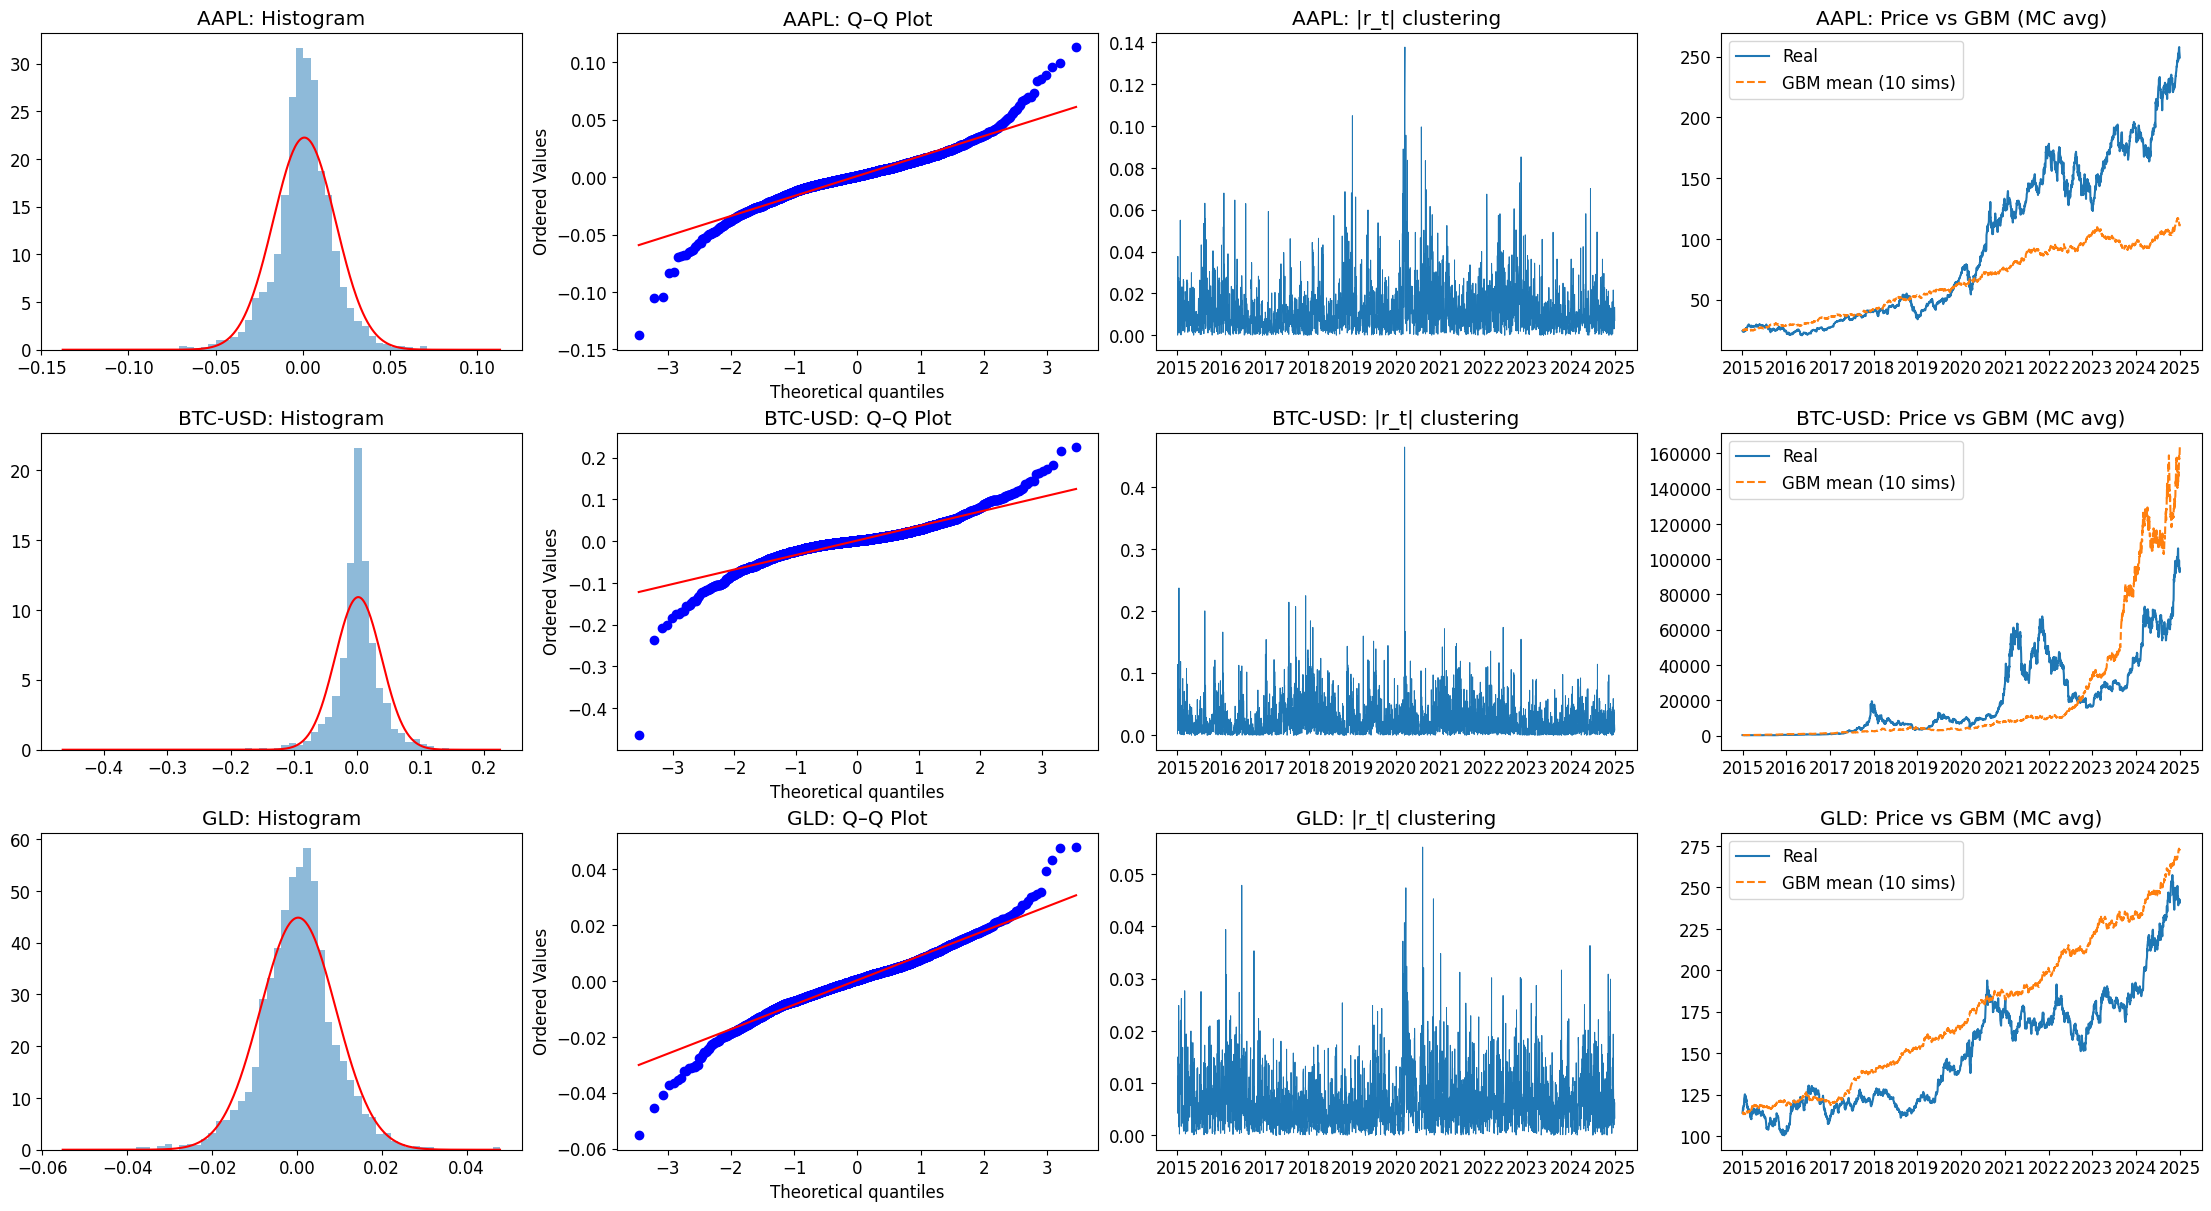

In [103]:
assets = ["AAPL", "BTC-USD", "GLD"]

fig, axes = plt.subplots(len(assets), 4,
                         figsize=(22, 12),
                         constrained_layout=True)

for i, ticker in enumerate(assets):
    prices, log_returns, mu, sigma = get_asset_data(ticker)
    plot_asset_row(ticker, prices, log_returns, mu, sigma, axes[i])

plt.show()


## Final Verdict:

We pitted the elegant **Black-Scholes (GBM)** model against the messy reality of the market. How did it do?:

### 1. The Bell Curve Lie (Histogram)
**Observation:** The model captures the "average" day quite well. The center of our histograms overlaps near perfectly with the theoretical curve.

**The Problem:** As we move away from the mean, the model loses precision. Real markets have **"Fat Tails"** i.e. extreme gains or losses happen far more often than the normal distribution predicts.

### 2. The Extremes (Q-Q Plot)
**Observation:** The Q-Q plots shows that the math breaks down at the extremes.

**The Reality:** If the market were truly normal, the dots would lie on the red line. Instead, they curve off sharply at the ends. This tells us that events that are predicted to be vanishingly rare under a normal distribution are actually quite common in real financial markets.

### 3. Panic comes in Waves (Volatility Clustering)
**Observation:** Our model assumes risk ($\sigma$) is constant forever.

**The Reality:** Volatility in the real world is far from constant.
Looking at the time-series, we see clear **spikes**, most notably around 2020-2021 during the pandemic.

### 4. Different Assets have different Behavior
**Observation:** One size does not fit all.
*   **Gold (GLD):** With historically lower volatility fits the model reasonably well because it's a stable store of value.
*   **Apple (AAPL):** A middle ground. It follows the drift but has occasional shocks.
*   **Bitcoin (BTC):** The high volatility breaks the model almost immediately, creating massive deviations between the smooth GBM prediction and the jagged reality.

**Conclusion:**
Geometric Brownian Motion is a good baseline, but it's an over-simplification. To trade strictly based on this model is to bet that history will be smooth. As the charts show, history is anything but.

## References

1. **Einstein, A.** (1905).  
   *On the Motion of Small Particles Suspended in Liquids at Rest Required by the Molecular-Kinetic Theory of Heat.*  
   Annalen der Physik, **17**, 549–560.

2. **Fick, A.** (1855).  
   *On Liquid Diffusion.*  
   Philosophical Magazine, **10**, 30–39.

3. **Black, F., & Scholes, M.** (1973).  
   *The Pricing of Options and Corporate Liabilities.*  
   Journal of Political Economy, **81**(3), 637–654.

4. **Bouchaud, J.-P., & Potters, M.** (2003).  
   *Theory of Financial Risk and Derivative Pricing.*  
   Cambridge University Press.

5. **Shreve, S. E.** (2004).  
   *Stochastic Calculus for Finance I: The Binomial Asset Pricing Model.*  
   Springer.

7. **Hingtgen, R.** (2025).  
   *Intro to Financial Mathematics Lecture Notes.*  
   UCSC course materials, Fall Quarter.

8. **Columbia University.**  
   *Black–Scholes Option Pricing – Lecture Notes.*  
   Department of Mathematics / Financial Mathematics.

9. **Wikipedia contributors.**  
   *Black–Scholes model.*  
   https://en.wikipedia.org/wiki/Black%E2%80%93Scholes_model

10. **OpenAI (ChatGPT).**  
    *Assistance with code debugging, syntax ideas, mathematical intuition, and explanatory markdown.*  
    Used as an interactive aid for understanding theory and clarifying notation; all final reasoning and implementation decisions were made by the author.